# Sprint 3 - Price Prediction

This notebook is part of **Sprint 3**, the final sprint in our capstone project. Building upon the findings from previous deliverables, we now focus on **model optimization, evaluation, and interpretation**. The goal of this sprint is to enhance the performance of our Ridge Regression model and gain deeper insights into feature importance.

### In this notebook, we will:

- **Incorporate learnings from previous sprints**  
  - Refine preprocessing steps and apply advanced EDA techniques.  
  - Leverage insights from baseline models to enhance our approach.  

- **Optimize text-related features**  
  - **Tune the number of tokens** for each text column to improve predictive performance.  
  - Apply Natural Language Processing (NLP) techniques to enhance feature extraction.  

- **Apply SHAP (SHapley Additive exPlanations) for model interpretation**  
  - Understand feature importance and interaction effects.  
  - Identify key textual and numerical features contributing to model predictions.  
  - Utilize SHAP values to guide feature optimization efforts.  

- **Evaluate and fine-tune our Ridge Regression model**  
  - Maintain a consistent evaluation framework using metrics such as R², RMSE, and MAE.  
  - Aim to improve upon the previous performance of **52.9% training accuracy** and **51.2% testing accuracy**.  

- **Prepare a robust pipeline for final submission**  
  - Ensure reproducibility and scalability of the model.  
  - Document findings and improvements for future reference.  

This sprint aims to achieve optimal performance through meticulous feature tuning and thorough model interpretation using SHAP values. Let's dive in!  




In [2]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack


In [3]:
!pip install shap

In [4]:
main_df = pd.read_csv('data/train.tsv', sep= '\t')
main_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
main_df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

In [6]:
main_df.drop(columns=['train_id'], inplace=True)

In [7]:
main_df.shape

(1482535, 7)

In [8]:
main_df.tail()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...
1482534,Brand new lux de ville wallet,1,Women/Women's Accessories/Wallets,NaN,22.0,0,"New with tag, red with sparkle. Firm price, no..."


### Inspecting Unique Values

Let's take a quick look at the unique values in the `item_condition_id` column to understand the range of item conditions present in the dataset.


In [9]:
main_df['item_condition_id'].unique()

array([3, 1, 2, 4, 5])

### Target Variable Range

We'll perform a quick check on the minimum and maximum values of our target variable to get a sense of the value range we are working with


In [10]:
#Checking min and max prices to understand what range of prices we can expect for this dataset.

max_price = main_df['price'].max()
min_price = main_df['price'].min()

print(f'Minimum price in the dataset: {min_price}')
print(f'Maximum price in the dataset: {max_price}')

Minimum price in the dataset: 0.0
Maximum price in the dataset: 2009.0


In [11]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   name               1482535 non-null  object 
 1   item_condition_id  1482535 non-null  int64  
 2   category_name      1476208 non-null  object 
 3   brand_name         849853 non-null   object 
 4   price              1482535 non-null  float64
 5   shipping           1482535 non-null  int64  
 6   item_description   1482529 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 79.2+ MB


### Handling Duplicates and Missing Values

We will check for duplicate and null values in the dataset. Since these entries are not useful for our analysis, they will be dropped.


In [12]:
main_df.duplicated().sum()

49

In [13]:
#Dropping duplicates

main_df.drop_duplicates(inplace=True)


In [14]:
main_df.isna().sum()


name                      0
item_condition_id         0
category_name          6327
brand_name           632641
price                     0
shipping                  0
item_description          6
dtype: int64

In [15]:
main_df.isna().mean()

name                 0.000000
item_condition_id    0.000000
category_name        0.004268
brand_name           0.426743
price                0.000000
shipping             0.000000
item_description     0.000004
dtype: float64

<Axes: >

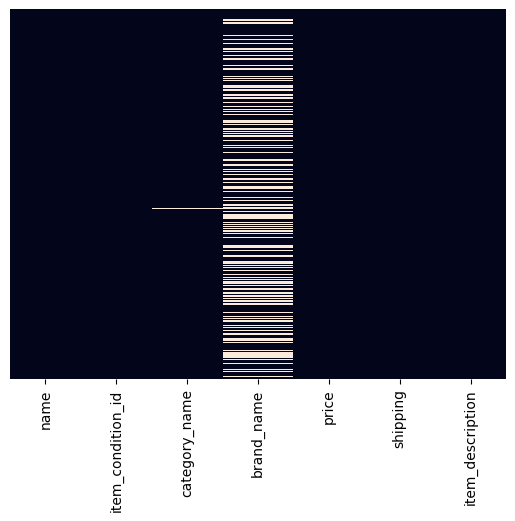

In [16]:
#Heatmap to see null values in the dataset

sns.heatmap(main_df.isnull(),
            yticklabels=False,
            cbar=False)

In [17]:
#Dropping Null value rows because the most part is as brand name and we cant make that information up. because we have a vary large amout of rowsin the full dataset we can afford to loose some rows

main_df = main_df.dropna()


In [18]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 846973 entries, 1 to 1482531
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               846973 non-null  object 
 1   item_condition_id  846973 non-null  int64  
 2   category_name      846973 non-null  object 
 3   brand_name         846973 non-null  object 
 4   price              846973 non-null  float64
 5   shipping           846973 non-null  int64  
 6   item_description   846973 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 51.7+ MB


### Distribution of Non-Text Variables

Now that we have removed duplicates and null values, we will plot the distribution of the non-text variables to better understand their behavior before moving on to preprocessing the text data. For these plots we will create a data frame ito inlcude just the columns we need, dropping the text columns.


In [19]:
# Dropping price because it's my y variable and train_id because it doesn't have any meaning for our analysis
plot_columns_distribution = main_df.drop(['name', 'category_name', 'item_description', 'brand_name'], axis=1)

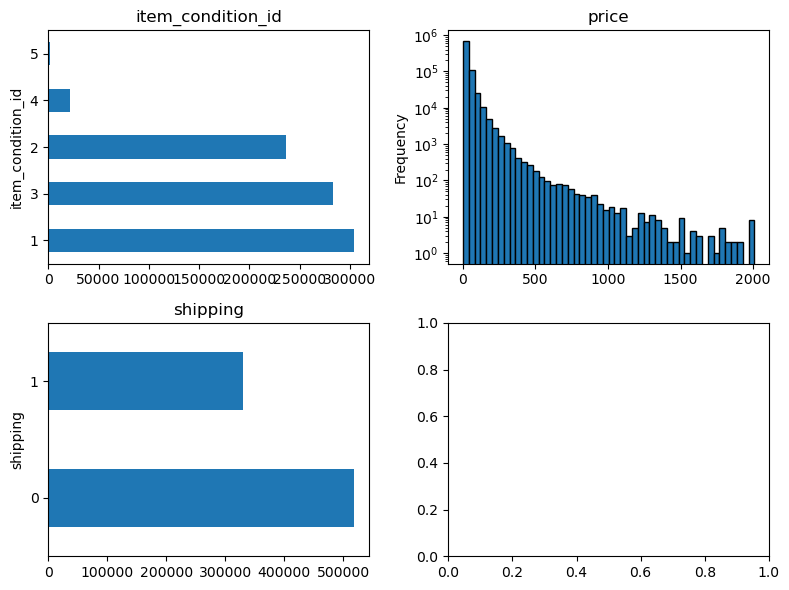

In [20]:
# Write a loop, that goes through all column names, and creates a count plot for each one 
# Specify subplot dimensions 
nrows = 2
ncols = 2

# Create "subplot" grid 
plt.subplots(nrows, ncols, figsize=(8, 6))

# Loop through positions and add plots 
for i, col in enumerate(plot_columns_distribution.columns): 
    plt.subplot(nrows, ncols, i + 1)
    if col == 'price':  # Check if the column is "price"
       main_df[col].plot(kind='hist', bins=50, edgecolor='black', log=True).set_title(col) 
    else:
        main_df[col].value_counts().plot(kind='barh').set_title(col)

plt.tight_layout()
plt.show()


### Observations on Variable Distribution

Our goal here is to understand the distribution of the non-text variables.  
The target variable, which is the most important, shows a noticeable right skew. This indicates that:

- There are many lower values  
- Higher values are less frequent  

While this skew isn't a major issue when using the full dataset due to the large number of records, it could become more problematic when we take a sample to optimize model training time. In such cases, the imbalance might be amplified, potentially affecting model performance.


### Text Preprocessing Setup

After completing the initial EDA, we will begin preprocessing the text data.  

- First, we will create a custom tokenizer and pass it to `CountVectorizer` to extract tokens from the following columns:  
  - `name`  
  - `category_name`  
  - `item_description`  
  - `brand_name`  

The goal is to ensure that all text data is well-organized and clean before we move on to modeling, starting with a **Linear Regression**.

In [21]:
# Defining the tokenizer function
forbidden_char = string.punctuation + "1234567890"

def custom_tokenizer(text):
    # Lowercase text
    text = text.lower()
    
    # Replacing '/' with space
    text = text.replace("/", " ")

    # Remove special characters
    text = re.sub(f"[{forbidden_char}]", "", text)

    # Split into words as tokens
    tokens = text.split()

    # Filter stopwords
    tokens = [tok for tok in tokens if tok not in ENGLISH_STOP_WORDS and len(tok) > 2]

    return tokens

### Creating a Sample for Modeling

Now that we have created our tokenizer, we will create a sample of the dataset.  

Since the next steps involve tokenizing and vectorizing the text data—operations that can be time-consuming on the full dataset—we will work with a smaller sample to speed up processing.  

The `sample_df` will be used going forward for splitting into train and test sets, as well as for preprocessing and modeling.

### Ensuring Target Distribution in Sample

In the cell below, we ensure that the sampled data maintains a similar distribution of the target variable `price` compared to the original dataset.  

This approach helps us:  
- Preserve the characteristics of the full dataset  
- Reduce the dataset size to optimize processing time  
- Still make meaningful predictions without losing important information


In [22]:
# Step 1: Bin the target variable
main_df['price_bin'] = pd.qcut(main_df['price'], q=50, duplicates='drop')

# Step 2: Perform stratified sampling based on the binned price
sample_df = main_df.groupby('price_bin', group_keys=False).apply(lambda x: x.sample(frac=0.2, random_state=42))

# Optional: Drop the temporary bin column
sample_df = sample_df.drop(columns='price_bin')


In [23]:
#Remove prices Higher than 1000
sample_df = sample_df[sample_df['price'] < 1000]

### Visualizing Target Distribution After Sampling

After sampling the data, we will plot the distribution of the target variable `price`.  

This step helps us understand whether the sampling process preserved the original distribution and whether any further transformation is needed.  

Since regression models tend to perform better with normally distributed target variables, this visualization will guide us in deciding if any adjustments (e.g., log transformation) are necessary.


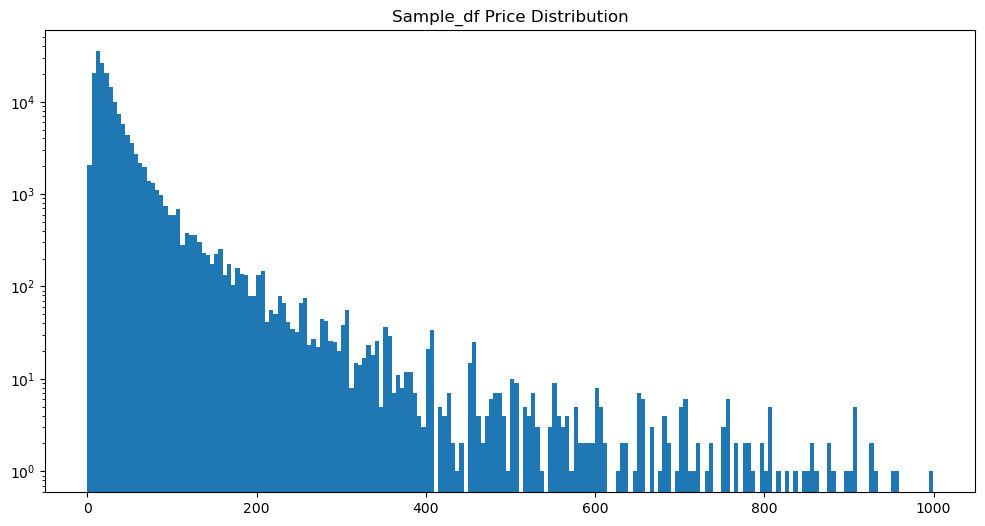

In [24]:
plt.figure(figsize=(12, 6))
plt.hist(sample_df['price'], bins=200, log=True)
plt.title('Sample_df Price Distribution')
plt.show()

### Applying Log Transformation to the Target Variable

The target variable `price` is heavily skewed to the right, as seen in the distribution plot. To improve model performance, we will apply a **log transformation** to normalize this distribution.

Taking the log of the values helps because:

- It compresses the range of higher values  
- It stretches out the lower values  
- This reduces skewness and results in a more symmetric, normal-like distribution  

Normalizing the target variable is important, as many regression models assume or perform better when the target follows a normal distribution.

After modeling, we will reverse the log transformation to return predictions to their original price scale.


<Axes: xlabel='price', ylabel='Count'>

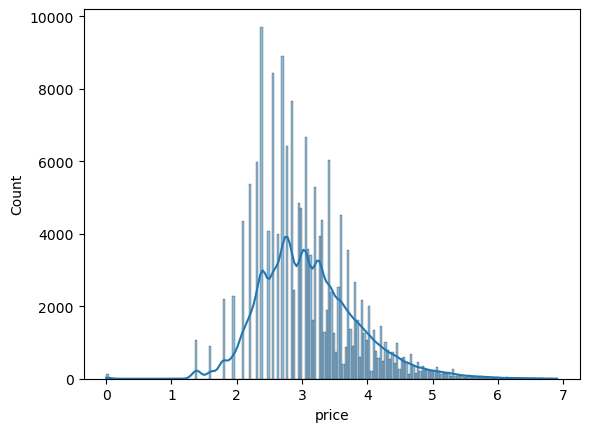

In [25]:
# Example target
target = sample_df['price']

# Apply log transform
sample_df['price'] = np.log1p(target)  # log1p = log(1 + x)

# Check transformed distribution
sns.histplot(sample_df['price'], kde=True)

### Visualizing the Transformed Target Variable

After applying the log transformation to the `price` column, we can see from the plot that the distribution is now much closer to a normal distribution.  

This confirms that the transformation was effective and will likely help improve model performance.


In [26]:
sample_df.shape

(169367, 7)

In [27]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169367 entries, 312250 to 241406
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               169367 non-null  object 
 1   item_condition_id  169367 non-null  int64  
 2   category_name      169367 non-null  object 
 3   brand_name         169367 non-null  object 
 4   price              169367 non-null  float64
 5   shipping           169367 non-null  int64  
 6   item_description   169367 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 10.3+ MB


### Train-Test Split

Now we will separate our features (`X`) and target variable (`y`), and split the data into training and testing sets.  

This will allow us to train our models on one portion of the data and evaluate their performance on unseen data to ensure generalization.


In [28]:
#Separating the data into X and y
x = sample_df.drop('price', axis=1)
y_log = sample_df['price']

In [29]:
# Splitting the data into train and test
# Bin the target variable into quantiles
y_log_binned = pd.qcut(y_log, q=50, duplicates='drop')  # 10 quantile bins

# Now use stratification on the binned version
x_train, x_test, y_train_log, y_test_log = train_test_split(
    x, y_log, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_log_binned
)


> **Note:** In the train-test split step above, we used `stratify` along with `pd.qcut` to ensure that the distribution of the target variable is maintained in both training and testing sets.


### Preparing Text Columns for Vectorization

In this step, we extract the four text columns from `X_train` and `X_test`:

- `name`  
- `category_name`  
- `item_description`  
- `brand_name`  

We handle each column separately because `CountVectorizer` expects a list of strings as input.  

Additionally, we will vectorize each column individually and add a unique prefix to each token, indicating which column it came from.  

This approach gives us more context and avoids confusion between similar words from different fields when we later combine everything into `X_train_final`.

In [30]:
# x_train text columns separation
x_train_name = x_train['name']

x_train_desc = x_train['item_description']

x_train_brand = x_train['brand_name']

x_train_cat = x_train['category_name']

# x_test text columns separation
x_test_name = x_test['name']

x_test_desc = x_test['item_description']

x_test_brand = x_test['brand_name']

x_test_cat = x_test['category_name']


### Vectorizing Text Columns and Combining Features

In the cell below, we vectorize the text columns separately:

- `name`  
- `item_description`  
- `brand_name`  
- `category_name`  

Each column is processed individually to allow us to customize the tokenization and add unique prefixes for better context.

After vectorization, we combine all the resulting sparse matrices using `hstack` to create the final feature sets for training and testing.


In [31]:
# Initialize separate vectorizers for each column
vectorizer_name = CountVectorizer(tokenizer=custom_tokenizer, min_df=50, max_features=200)
vectorizer_desc = CountVectorizer(tokenizer=custom_tokenizer,min_df=50, ngram_range=(1, 2), max_features=300)
vectorizer_brand = CountVectorizer(tokenizer=custom_tokenizer, min_df=50,ngram_range=(1, 2), max_features=500)
vectorizer_cat = CountVectorizer(tokenizer=custom_tokenizer, min_df=50,ngram_range=(1, 2), max_features=600)

# Fit and transform on train data, transform on test data
X_train_name = vectorizer_name.fit_transform(x_train_name)
X_test_name = vectorizer_name.transform(x_test_name)

X_train_desc = vectorizer_desc.fit_transform(x_train_desc)
X_test_desc = vectorizer_desc.transform(x_test_desc)

X_train_brand = vectorizer_brand.fit_transform(x_train_brand)
X_test_brand = vectorizer_brand.transform(x_test_brand)

X_train_cat = vectorizer_cat.fit_transform(x_train_cat)
X_test_cat = vectorizer_cat.transform(x_test_cat)

# Combine all transformed columns into final training and test sets
X_train_text = hstack([X_train_name, X_train_desc, X_train_brand, X_train_cat])
X_test_text = hstack([X_test_name, X_test_desc, X_test_brand, X_test_cat])



/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Finalizing Text Features and Merging with Numerical Data

In this step:

- We extract feature names from each vectorized text column.
- Each feature name is combined with a prefix indicating which column the token came from (`name`, `item_description`, `brand_name`, `category_name`) for better clarity and context.
- All tokens are then converted into a single DataFrame.
- We reset the indexes to prepare for merging.

Finally, we merge the text features with the numerical variables from the original dataset to create:

- `X_train_final`  
- `X_test_final`  

These final datasets contain both the processed text and numerical features and are ready for modeling.



In [32]:
# Step 1: Get feature names from each vectorizer and add prefixes
feature_names_name = [f"name_{feat}" for feat in vectorizer_name.get_feature_names_out()]
feature_names_desc = [f"desc_{feat}" for feat in vectorizer_desc.get_feature_names_out()]
feature_names_brand = [f"brand_{feat}" for feat in vectorizer_brand.get_feature_names_out()]
feature_names_cat = [f"cat_{feat}" for feat in vectorizer_cat.get_feature_names_out()]

# Combine all feature names
text_feature_names = feature_names_name + feature_names_desc + feature_names_brand + feature_names_cat

# Step 2: Convert sparse matrices to DataFrames
X_train_text_df = pd.DataFrame(X_train_text.toarray(), columns=text_feature_names)
X_test_text_df = pd.DataFrame(X_test_text.toarray(), columns=text_feature_names)

# Step 3: Reset indices to align with numerical features before merging
X_train_text_df.reset_index(drop=True, inplace=True)
X_test_text_df.reset_index(drop=True, inplace=True)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

# Step 4: Merge text features back with numerical features
X_train_final = pd.concat([x_train.drop(columns=["name", "item_description", "brand_name", "category_name"]), X_train_text_df], axis=1)
X_test_final = pd.concat([x_test.drop(columns=["name", "item_description", "brand_name", "category_name"]), X_test_text_df], axis=1)


In [33]:
X_train_final.shape


(135493, 1602)

### Most Frequent Tokens by Text Column

Before moving on to modeling, we’ll quickly inspect the most frequent tokens from each of the text columns we processed.

We'll plot the top 20 tokens for each column separately:

- `item_description`  
- `name`  
- `category_name`  
- `brand_name`  

This will help us better understand the common terms in each field and verify that our tokenization worked as expected.


In [34]:
# Create token counts to pass into the plots

token_count_name = X_train_final.filter(like='name', axis=1).sum().sort_values(ascending=False)
token_count_desc = X_train_final.filter(like='desc', axis=1).sum().sort_values(ascending=False)
token_count_cat = X_train_final.filter(like='cat', axis=1).sum().sort_values(ascending=False)
token_count_brand = X_train_final.filter(like='brand', axis=1).sum().sort_values(ascending=False)

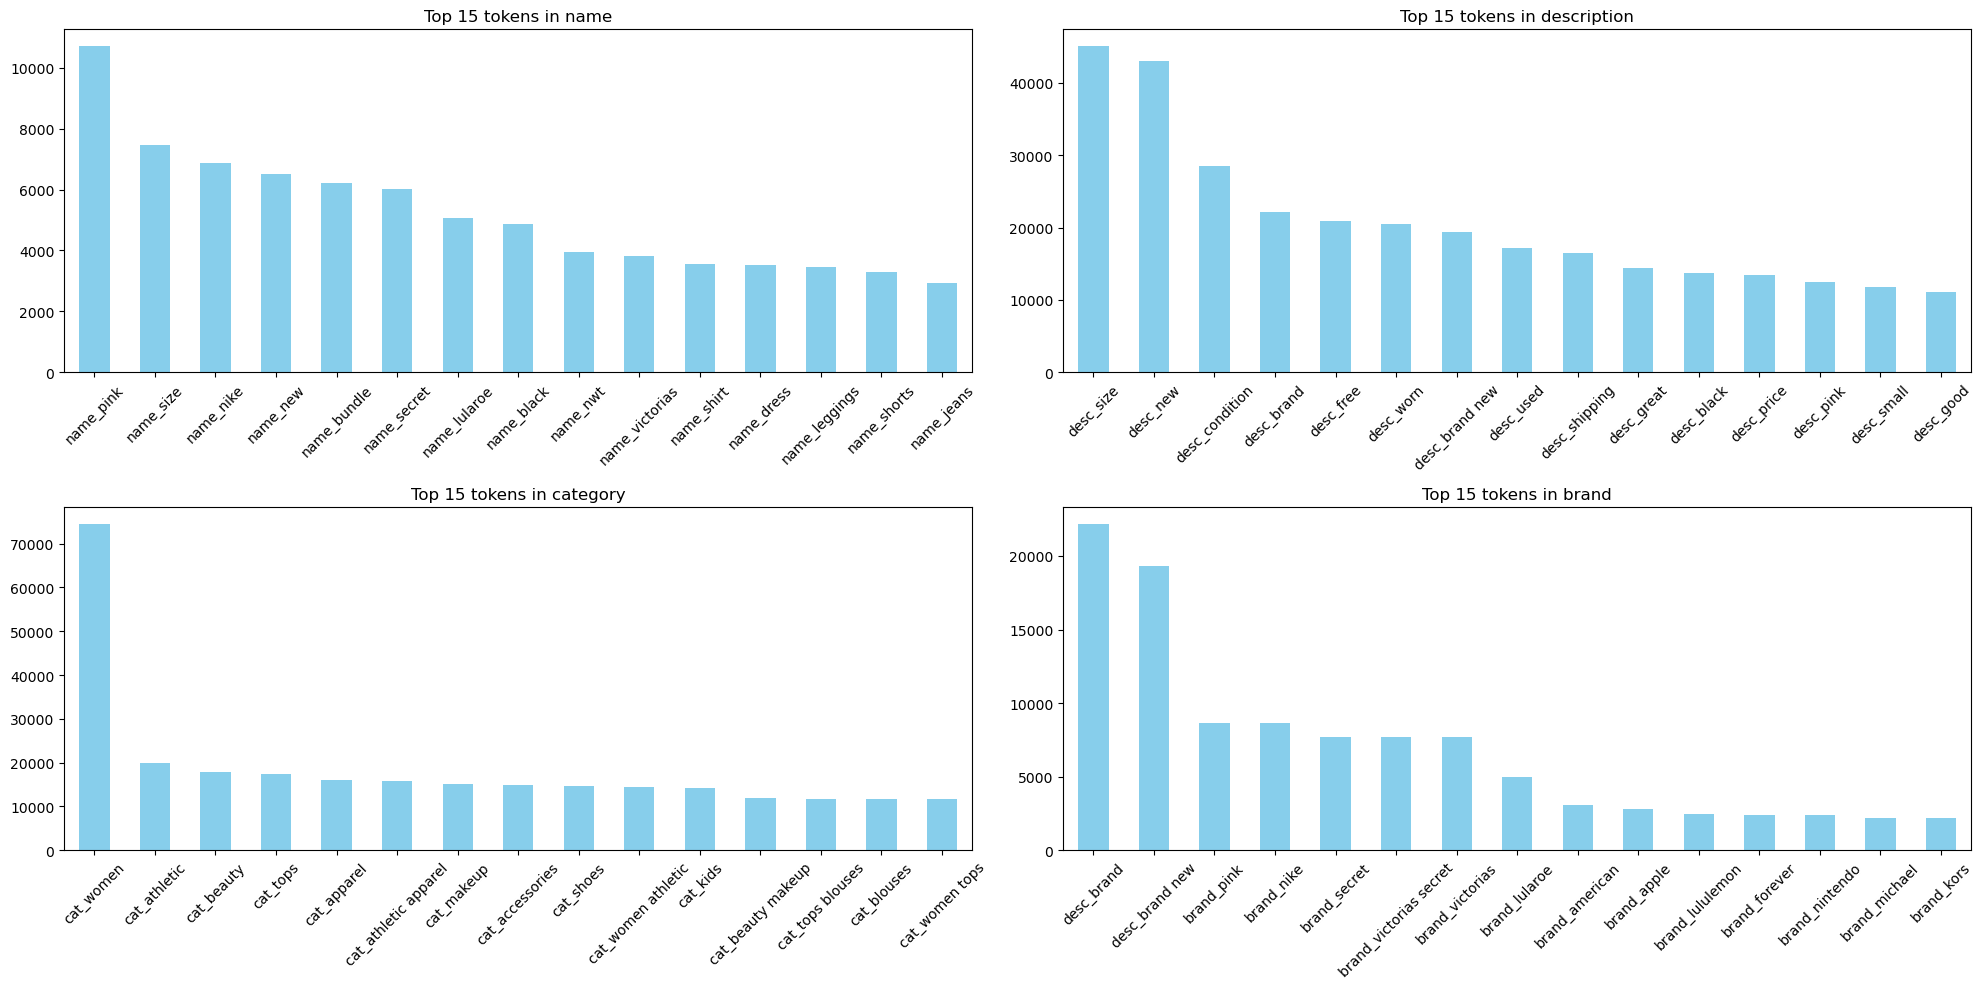

In [35]:
# Plotting the token counts

# Plot 4 different plots for each text column

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
token_count_name.head(15).plot(kind='bar', color='skyblue')
plt.xticks(rotation=45)
plt.title('Top 15 tokens in name')

plt.subplot(2, 2, 2)
token_count_desc.head(15).plot(kind='bar', color='skyblue')
plt.xticks(rotation=45)
plt.title('Top 15 tokens in description')

plt.subplot(2, 2, 3)
token_count_cat.head(15).plot(kind='bar', color='skyblue')
plt.xticks(rotation=45)
plt.title('Top 15 tokens in category')

plt.subplot(2, 2, 4)
token_count_brand.head(15).plot(kind='bar', color='skyblue')
plt.xticks(rotation=45)
plt.title('Top 15 tokens in brand')

plt.tight_layout()
plt.show()

### Token Frequency Analysis Across Text Features

The plots above display the top 15 most frequent tokens in each of the following text features: **name**, **item_description**, **category_name**, and **brand_name**.

#### Key Observations:

- **Name**
  - Common tokens include `pink`, `size`, `nike`, `bundle`, and `new`.
  - These likely reflect frequently sold items or common descriptive keywords in product titles.
  - Brands and conditions appear often, giving strong signals for product identification and pricing.

- **Item Description**
  - Frequently used tokens include `size`, `new`, `condition`, `brand`, `free`, and `used`.
  - These suggest that sellers commonly highlight product condition, size, and promotional details (like free shipping).
  - Such information is useful context for understanding price variations.

- **Category**
  - The token `women` appears far more frequently than others, followed by `athletic`, `beauty`, `tops`, and `apparel`.
  - This indicates that women's items dominate the dataset.
  - Category tokens help define the product segment, which can heavily influence price expectations.

- **Brand**
  - Most common tokens include `brand`, `brand new`, `pink`, `nike`, `secret`, and `victorias`.
  - Prominent brand names like `nike`, `lululemon`, and `michael kors` appear, which are likely associated with higher pricing.
  - Brand data can serve as a strong indicator of perceived value.

#### Conclusion:

These visualizations provide valuable insight into which tokens appear most often and how they may influence pricing. Understanding these patterns supports better feature engineering and model interpretation when predicting product prices.




### Model Evaluation Function

Before running our models, we'll define a function to streamline the evaluation process.  

This function will allow us to:

- Train and test multiple models efficiently  
- Display key performance metrics:
  - **Train and Test R² Scores**
  - **Root Mean Squared Error (RMSE)**
  - **Mean Absolute Error (MAE)**  

Since we applied a log transformation to the target variable earlier, the function will also reverse this transformation to bring predictions back to their original price scale before computing evaluation metrics.

These metrics will help us compare model performance and decide which models are worth fine-tuning further.

In [36]:
# Define a function that to show train and test scores, RMSE and MAE

def show_scores(model, X_train, X_test, y_train_log, y_test_log, model_name='Model'):
    # Predict in log scale
    y_train_pred_log = model.predict(X_train_final)
    y_test_pred_log = model.predict(X_test_final)

    # Transform back to original scale
    y_train_pred = np.expm1(y_train_pred_log)
    y_test_pred = np.expm1(y_test_pred_log)
    y_train = np.expm1(y_train_log)
    y_test = np.expm1(y_test_log)

    # R² scores in original scale
    train_score = model.score(X_train, y_train_log)
    test_score = model.score(X_test, y_test_log)

    # Metrics
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Output
    print(f'{model_name} Train R² (log scale): {train_score:.4f}')
    print(f'{model_name} Test R² (log scale): {test_score:.4f}')
    print(f'{model_name} Train MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}')
    print(f'{model_name} Test MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}')



### Running Baseline Models

Below, we begin instantiating several regression models and evaluating them using the function defined earlier.

> **Note:**  
> All models are trained and tested on just **20% of the full dataset** to reduce computation time.  
> These results are **baseline estimates** and not final — they are intended to help us quickly identify which models show potential and are worth further exploration.

Once we identify promising models, we can retrain them on a larger portion of the dataset and proceed with fine-tuning.

 # Linear Regression

In [37]:
# Instantiate Linear regression model
LinReg_L2 = Ridge()

# Fitting the model
LinReg_L2.fit(X_train_final, y_train_log)


Ridge()

In [38]:
#Score train and test, MAE and RMSE
show_scores(LinReg_L2, X_train_final, X_test_final, y_train_log, y_test_log, 'Linear Regression L2')


Linear Regression L2 Train R² (log scale): 0.5291
Linear Regression L2 Test R² (log scale): 0.5121
Linear Regression L2 Train MAE: 13.25, RMSE: 33.03
Linear Regression L2 Test MAE: 13.52, RMSE: 34.53


## Linear Regression with L2 Regularization – Model Evaluation

Our current model is a **Linear Regression with L2 Regularization (Ridge Regression)**. Below are the updated performance metrics:

- **Train R² (log scale):** 0.5291  
- **Test R² (log scale):** 0.5121  
- **Train MAE:** 13.25  
- **Train RMSE:** 33.03  
- **Test MAE:** 13.52  
- **Test RMSE:** 34.53  

---

### What These Metrics Mean

#### R² Score (Coefficient of Determination)
- The **R² score** indicates how much of the variance in the log-transformed target variable is explained by the model.
- Our Ridge Regression model explains:
  - About **52.9% of the variance on the training set**.
  - About **51.2% on the test set**.
- This shows the model captures **slightly more than half of the variability** in the data, which is a solid result for a linear model on log-transformed prices.

#### MAE (Mean Absolute Error)
- **MAE** reflects the average absolute error between predicted and actual values.
- A test MAE of **13.52** means the typical prediction is off by about **13.52 units** (in the same scale as your prices).
- The closeness between **train and test MAE** suggests the model is generalizing well and **not overfitting**.

#### RMSE (Root Mean Squared Error)
- **RMSE** emphasizes larger errors more than MAE.
- The test RMSE of **34.53** suggests that some predictions deviate more significantly from actual values.
- However, the train and test RMSE values are close, indicating consistent performance across both sets.

---

### Summary

- The model demonstrates **balanced performance** on training and testing data with **no major signs of overfitting**.
- It explains roughly **half of the variability** in product prices (in log scale), offering a **strong baseline**.
- The **error levels are acceptable**, but there's **potential for improvement** by exploring more complex models, better feature engineering, or additional data preprocessing.





### Analyzing Model Coefficients

Now let's plot the coefficients of our trained linear model to identify the most predictive tokens.

This analysis will help us:

- Understand which words (tokens) have the greatest influence on price predictions  
- Gain insight into how different terms from product descriptions, names, categories, or brands impact model behavior  

By visualizing the top positive and negative coefficients, we can better interpret what the model has learned.

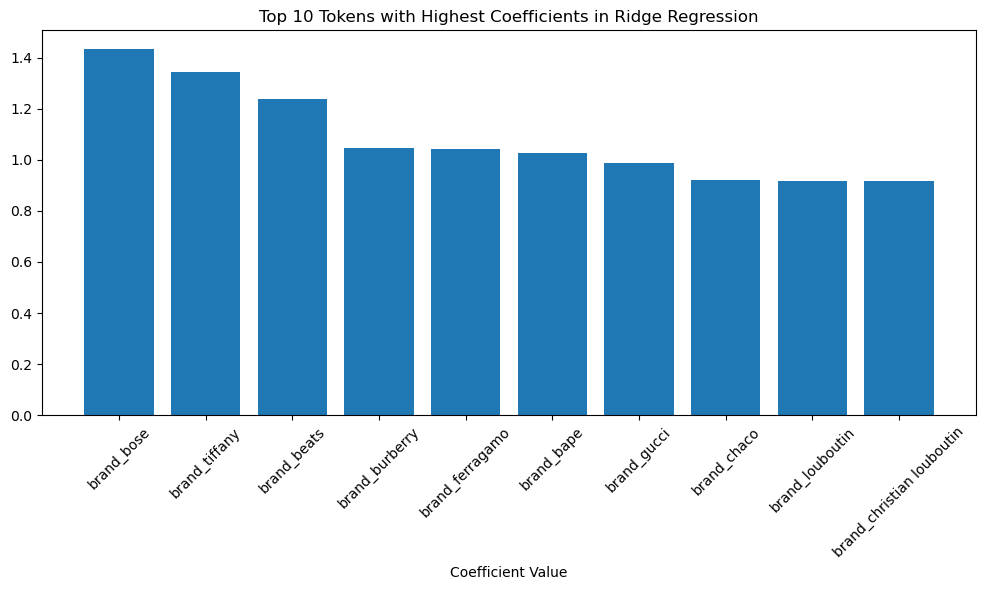

In [39]:

# Define numerical features
numerical_features = ['item_condition_id', 'shipping']

# Get the coefficients that correspond to the text features only
text_coefs = LinReg_L2.coef_[len(numerical_features):]

# Create a DataFrame for text features and their coefficients
text_coef_df = pd.DataFrame({
    'Token': text_feature_names,
    'Coefficient': text_coefs
})

# Get top 10 tokens with highest positive coefficients
top_tokens = text_coef_df.sort_values(by='Coefficient', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(top_tokens['Token'], top_tokens['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Tokens with Highest Coefficients in Ridge Regression')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




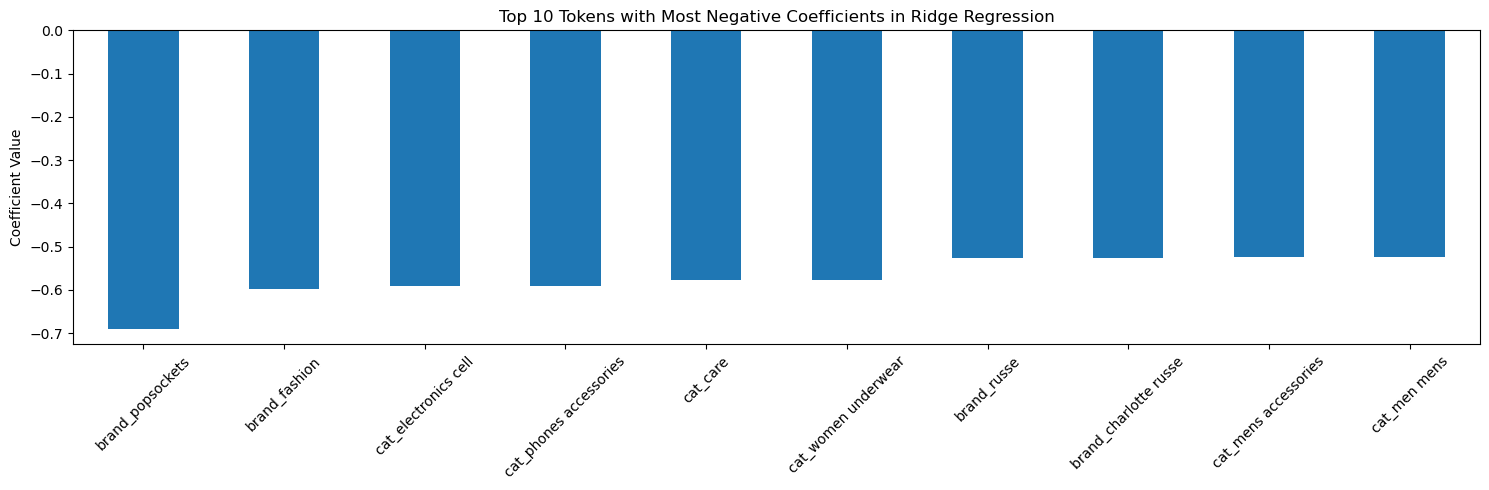

In [40]:
# Get the coefficients for text features only
ridge_coefs = LinReg_L2.coef_[len(numerical_features):]  # Skip numerical features

# Token names from the vectorizer
coef_names = text_feature_names  # or vectorizer.get_feature_names_out()

# Create a Series for plotting
coef_series = pd.Series(ridge_coefs, index=coef_names).sort_values()

# Plot the 20 lowest (most negative) coefficients
coef_series.head(10).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 10 Tokens with Most Negative Coefficients in Ridge Regression")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Insights from Coefficient Analysis

From the plotted coefficients, we can observe that tokens from the **brand** and **category** columns have significant predictive power in our linear regression model.

- These tokens contribute strongly to both increasing and decreasing predicted prices.
- This suggests that brand recognition and product categorization are key drivers of price within this dataset.
- At least for this baseline model, these features provide substantial value in capturing price variance.

These insights can guide future feature engineering and model tuning steps.



Now we are oing to apply the shapley values to understand our features importances a little better and be able to do some feature engeneiring in order to imporve our model.

In [41]:
import shap

# Initialize the LinearExplainer for Ridge Regression
explainer = shap.LinearExplainer(LinReg_L2, X_train_final)

# Obtain SHAP values
shap_values = explainer.shap_values(X_train_final)


In [42]:
shap_values.shape

(135493, 1602)

In [43]:
pd.Series(shap_values[0],X_train_final.columns).sort_values(ascending=True)

item_condition_id      -0.251418
cat_shoes              -0.048742
cat_underwear          -0.028285
cat_electronics        -0.023920
cat_athletic apparel   -0.021550
                          ...   
cat_women underwear     0.034550
cat_women               0.048072
shipping                0.083627
cat_kids                0.244101
cat_travel              0.548748
Length: 1602, dtype: float64

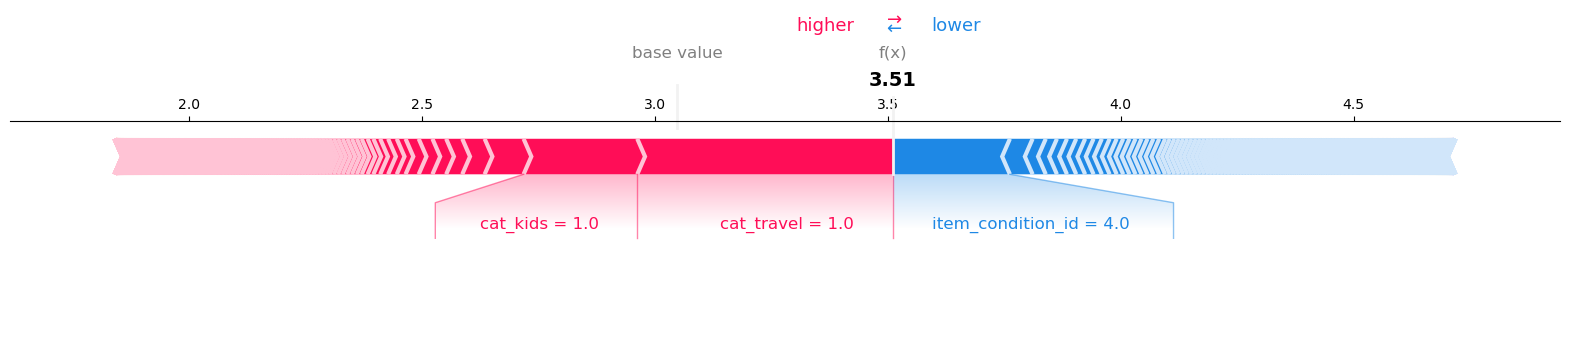

In [44]:
shap.initjs()  # Ensure this is called

# Render a force plot with matplotlib backup
shap.force_plot(explainer.expected_value, shap_values[0], X_train_final.iloc[0], 
                feature_names=X_train_final.columns, matplotlib=True)


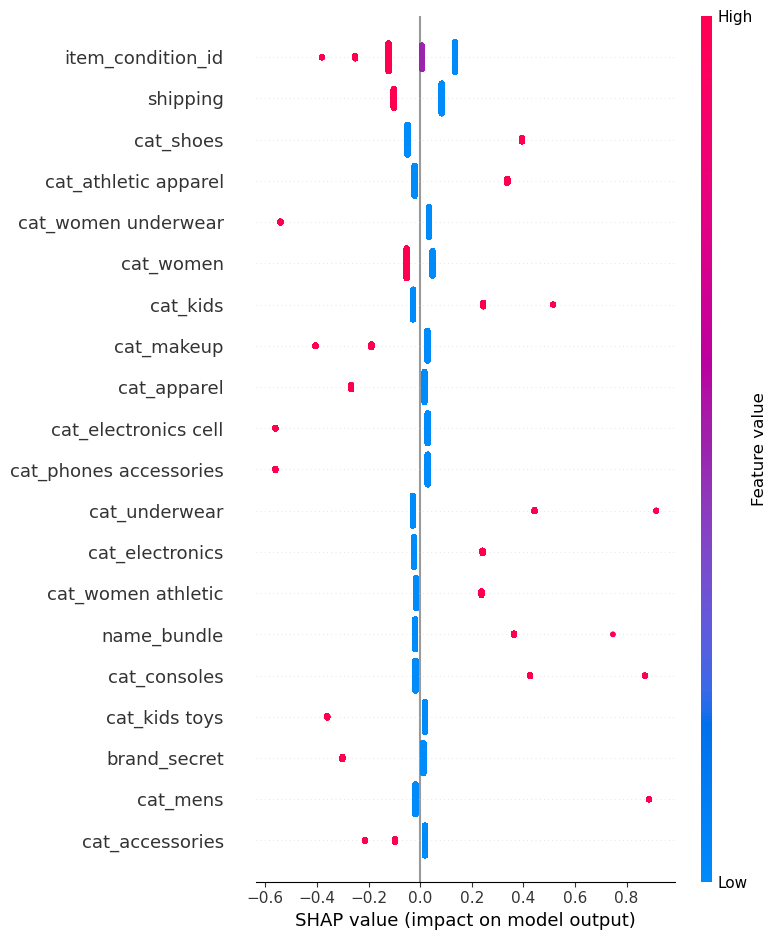

In [45]:
# Global interpretation - summary plot - type = 'dot'
shap.initjs()

shap.summary_plot(shap_values, features=X_train_final, feature_names=X_train_final.columns)

In [46]:
import joblib

# Assuming your trained Ridge Regression model is called `ridge_model`
joblib.dump(LinReg_L2, 'ridge_model.pkl')


['ridge_model.pkl']

## SHAP Value Analysis – Understanding Feature Importance

By leveraging **SHAP (SHapley Additive exPlanations)**, we gain valuable insights into how our model is making predictions and which features are most influential. The visualizations below illustrate the **feature importance and individual prediction explanations**.

---

### **Key Observations**

1. **Categorical Features Provide Strong Predictive Power**
   - The categories (`cat_kids`, `cat_travel`, `cat_shoes`, etc.) are significantly influential in the model's predictions.
   - The model effectively recognizes patterns associated with specific categories and subcategories, enhancing prediction accuracy.
   - For instance, categories like **`cat_kids`** and **`cat_travel`** heavily contribute to price predictions, as seen in the force plot.

2. **Brands Contribute to Enhanced Prediction Accuracy**
   - Brands such as **`brand_secret`** and others are critical features in the model, helping distinguish between higher and lower-priced products.
   - This demonstrates the model's ability to identify valuable information from branding, which directly impacts pricing.

3. **Item Condition & Shipping as Crucial Features**
   - As expected, the **`item_condition_id`** and **`shipping`** features are consistently among the most influential.
   - Better item condition (**lower numerical value**) tends to increase predicted price, while higher shipping costs can lower it.

4. **TF-IDF Text Features Are Also Valuable**
   - The contribution of text-based features, derived from the **TF-IDF Vectorizer**, is evident though not as dominant as categories or brands.
   - However, they still provide important contextual information, especially when combined with categorical data.

---

### **Visual Insights**

- The **force plot** clearly illustrates how individual features contribute to a specific prediction. Positive influences (pushing price higher) are shown in red, while negative influences (lowering price) are shown in blue.
- The **summary plot** highlights the overall impact of each feature across the entire dataset. Features further from the center contribute more to the predictions.
- Notably, **item condition**, **shipping**, and several categorical features consistently show substantial influence.

---

###  **Conclusion**

The SHAP analysis confirms that the model relies heavily on **categorical data, brand names, and condition-related features** to make accurate predictions. This understanding provides a clear path for potential improvements, such as:

- **Further refining category hierarchies.**
- **Enhancing brand feature representation.**
- **Exploring feature interactions for better performance.**

Would you like me to help you **integrate these SHAP visualizations into your Streamlit app** to make your presentation more interactive and informative? 
